# 過去ログからより良いエントリポイントを探求

### システムパスに一つ上のディレクトリ .. を追加

In [1]:
import sys
try:
    sys.path.index('..')
except ValueError:
    sys.path.append('..')

## ライブラリのインポート

In [2]:
import datetime
import re

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
    ticker as ticker,
)
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.plots import getMajorXTicks
from funcs.preprocs_no_qt import (
    get_date_formatted,
    get_ohlc4analysis,
    get_tick4analysis,
)
from sim.position_manager import PositionManager

## ソースファイルの指定

In [3]:
#code = '7203'
code = '8306'
dateStr = '20250310'
ohlc_csv = '../ohlc1m/ohlc1m_%s_%s.csv' % (code, dateStr)
tick_csv = '../tick/tick_%s_%s.csv' % (code, dateStr)

## 過去ログ (OHLC) の読み込み

In [4]:
df = pd.read_csv(ohlc_csv)
# OHLC データを Matplotlib で扱いやすいように整形
df = get_ohlc4analysis(df)
df

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff,Slope,IQR
2025-03-10 09:00:00,1931.5,1932.0,1926.5,1930.5,2160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 09:01:00,1929.5,1931.0,1926.5,1927.5,436000.0,1930.13,1931.00,1926.5,1928.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 09:02:00,1927.5,1927.5,1923.5,1924.0,364100.0,1929.38,1929.38,1923.5,1925.63,-1.0,1923.50,0.02,1923.5,0.0,0.0,NaN,4.5
2025-03-10 09:03:00,1924.5,1926.0,1922.0,1924.5,350400.0,1927.50,1927.50,1922.0,1924.25,1.0,1922.00,0.02,1923.5,0.0,0.0,NaN,5.0
2025-03-10 09:04:00,1925.0,1925.5,1922.0,1922.5,331600.0,1925.88,1925.88,1922.0,1923.75,-1.0,1925.88,0.02,1922.0,0.0,0.0,NaN,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 15:29:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.head(20)

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff,Slope,IQR
2025-03-10 09:00:00,1931.5,1932.0,1926.5,1930.5,2160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 09:01:00,1929.5,1931.0,1926.5,1927.5,436000.0,1930.13,1931.00,1926.50,1928.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-10 09:02:00,1927.5,1927.5,1923.5,1924.0,364100.0,1929.38,1929.38,1923.50,1925.63,-1.0,1923.50,0.02,1923.50,0.0,0.0,NaN,4.50
2025-03-10 09:03:00,1924.5,1926.0,1922.0,1924.5,350400.0,1927.50,1927.50,1922.00,1924.25,1.0,1922.00,0.02,1923.50,0.0,0.0,NaN,5.00
2025-03-10 09:04:00,1925.0,1925.5,1922.0,1922.5,331600.0,1925.88,1925.88,1922.00,1923.75,-1.0,1925.88,0.02,1922.00,0.0,0.0,NaN,1.50
2025-03-10 09:05:00,1922.5,1923.0,1921.0,1922.0,151200.0,1924.81,1924.81,1921.00,1922.13,1.0,1921.00,0.02,1925.88,0.0,0.0,NaN,2.88
2025-03-10 09:06:00,1922.0,1922.5,1920.0,1922.0,267800.0,1923.47,1923.47,1920.00,1921.63,-1.0,1920.00,0.02,1921.00,0.0,0.0,NaN,1.00
2025-03-10 09:07:00,1922.5,1923.5,1921.0,1922.0,109700.0,1922.55,1923.50,1921.00,1922.25,1.0,1923.50,0.02,1920.00,0.0,0.0,NaN,1.00
2025-03-10 09:08:00,1921.5,1922.0,1919.5,1920.0,126300.0,1922.40,1922.40,1919.50,1920.75,-1.0,1922.40,0.02,1923.50,0.0,0.0,NaN,0.88
2025-03-10 09:09:00,1920.0,1921.5,1918.0,1921.5,224700.0,1921.57,1921.57,1918.00,1920.25,-1.0,1918.00,0.04,1923.28,1.0,-1.5,-1.5,2.00


## 過去ログ (Tick) の読み込み

In [6]:
df_tick = pd.read_csv(tick_csv)
# Tick データを Matplotlib で扱いやすいように整形
dateFmt = get_date_formatted(dateStr)
df_tick = get_tick4analysis(df_tick, dateFmt)
df_tick

,Price
Datetime,
2025-03-10 09:00:00,1931.0
2025-03-10 09:00:01,1930.0
2025-03-10 09:00:04,1929.5
2025-03-10 09:00:05,1928.0
2025-03-10 09:00:07,1927.5
...,...
2025-03-10 15:24:53,1924.0
2025-03-10 15:24:55,1924.0
2025-03-10 15:24:57,1923.5


# シンプルな売買シミュレーション

---
### 課題

トレンド反転後、period = 1 でエントリして、どれだけ収益を最大化できるか？

In [7]:
def eval_losscut(posman, t, price):
    try:
        if posman.get_profit(t, price) <= 0:
            return True
        else:
            return False
    except TypeError:
        return False

### ループ

In [8]:
# 時間定数
dt_start = pd.to_datetime('%s 09:00:00' % dateFmt)
dt_end = pd.to_datetime('%s 15:24:50' % dateFmt)
# ループの刻み幅
td = datetime.timedelta(seconds=1)
# トレンドを確認できるのは 1 分 1 秒後
td_delay = datetime.timedelta(minutes=1, seconds=1)

price_delta_min = 0.5
unit = 100
posman = PositionManager(unit)

period = 0
total = 0

preopen = True
period_opened = 0

t = dt_start
while t <= dt_end:
    if t in df_tick.index:
        # ティックデータから現在価格の更新
        price = df_tick.at[t, 'Price']
        posman.eval_profit(t, price)

    # 1 秒後にトレンド確認
    t_target = t - td_delay
    if dt_start < t_target and t_target.second == 0:
        # トレンドが更新されるのは分単位（= 0 秒）
        # 算出された 1 秒後に売買情報を更新
        if t_target in df.index:
            # 算出した指標を取得
            trend = df.at[t_target, 'TREND']
            period_pre = period
            period = df.at[t_target, 'Period']
            diff = df.at[t_target, 'Diff']
            slope = df.at[t_target, 'Slope']
            iqr = df.at[t_target, 'IQR']

            if np.isnan(trend):
                # nan だったら何もしない
                pass
    
            # トレンド反転か判定
            elif posman.get_trend() != trend:
                # 建玉を持って入れば返済
                if posman.has_position():
                    note = '返済 priod = %d' % period_pre
                    posman.close(t, price, note)

                # 保持しているトレンドを更新
                posman.set_trend(trend)
                preopen = True
            elif posman.has_position() and 0 < period - period_opened:
                # 建玉有り
                if eval_losscut(posman, t, price) and 0:
                    note = '損切 priod = %d' % period
                    posman.close(t, price, note)                    
            elif preopen and 0 < diff:
                # 建玉無し
                # エントリ
                note = 'priod = %d' % period
                posman.open(t, price, note)
                preopen = False
                period_opened = period
            else:
                # 建玉無し
                # エントリ条件外
                pass
        elif posman.has_position() and 0 < period - period_opened:
            # 建玉有り
            if eval_losscut(posman, t, price):
                note = '損切 priod = %d' % period
                posman.close(t, price, note)                    
        else:
            # 建玉無し
            pass
    elif posman.has_position() and 0 < period - period_opened:
        # 建玉有り
        if eval_losscut(posman, t, price):
            note = '損切 priod = %d' % period
            posman.close(t, price, note)                    
    else:
        # 建玉無し
        pass

    # 時刻を１秒インクリメント
    t += td

# まだ建玉を持っていれば返済
if posman.has_position():
    note = 'priod = %d, 強制' % period_pre
    posman.close(t_target, price, note)

print(posman.get_order_history())
total = posman.get_total()
print('---\n実現損益', '{:+,}'.format(total))

delta = df['High'].max() - df['Low'].min()
print('パフォーマンス {:+,.1f}%'.format(total/delta))

df_profit = posman.get_profit_history()

   Order             Datetime Position   Price Profit           Note
0      1  2025-03-10 09:11:01       売建  1919.5    NaN      priod = 2
1      1  2025-03-10 09:12:02       買埋  1920.5 -100.0   損切 priod = 3
2      2  2025-03-10 09:14:01       買建  1927.0    NaN      priod = 1
3      2  2025-03-10 09:15:02       売埋  1926.0 -100.0   損切 priod = 2
4      3  2025-03-10 09:35:01       買建  1925.0    NaN      priod = 1
5      3  2025-03-10 09:36:02       売埋  1924.0 -100.0   損切 priod = 2
6      4  2025-03-10 10:03:01       買建  1929.5    NaN      priod = 1
7      4  2025-03-10 10:04:02       売埋  1928.0 -150.0   損切 priod = 2
8      5  2025-03-10 10:23:01       売建  1926.5    NaN      priod = 2
9      5  2025-03-10 10:24:02       買埋  1927.0  -50.0   損切 priod = 3
10     6  2025-03-10 10:37:01       買建  1929.0    NaN      priod = 6
11     6  2025-03-10 10:38:02       売埋  1928.5  -50.0   損切 priod = 7
12     7  2025-03-10 10:57:01       買建  1930.5    NaN      priod = 1
13     7  2025-03-10 10:58:17     

## チャート

### フォント設定

In [9]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 14

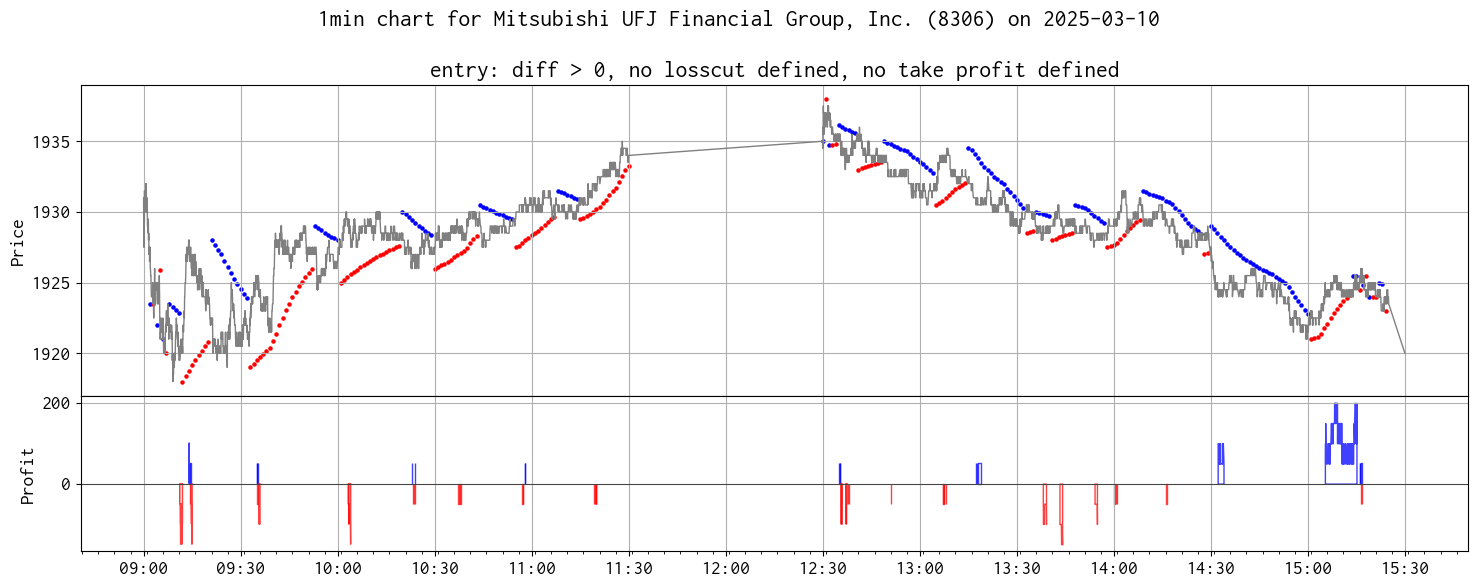

In [10]:
fig = plt.figure(figsize=(15, 6))

n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
ax = dict()
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

# Tick
ax[0].plot(df_tick, linewidth=1, color='gray',)

# PSAR bear - Downward trend
df_bear = df[df['TREND'] < 0]
ax[0].scatter(x=df_bear.index, y=df_bear['PSAR'], color='blue', s=5,)

# PSAR bull - Upward trend
df_bull = df[df['TREND'] > 0]
ax[0].scatter(x=df_bull.index, y=df_bull['PSAR'], color='red', s=5,)

tick_position, tick_labels = getMajorXTicks(df)
ax[0].set_xticks(ticks=tick_position, labels=tick_labels,)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_ylabel('Price')

order = 0
list_x = list()
list_y = list()
for r in range(len(df_profit)):
    t = df_profit.index[r]
    if order != df_profit.at[t, 'Order']:
        order = df_profit.at[t, 'Order']
        if len(list_x) > 0:
            x = np.array(list_x)
            y = np.array(list_y)
            ax[1].fill_between(x, y, where=(y > 0), ec='#00f', fc='white', alpha=0.75)
            ax[1].fill_between(x, y, where=(y < 0), ec='#f00', fc='white', alpha=0.75)
        list_x = list()
        list_y = list()

    list_x.append(t)
    list_y.append(df_profit.at[t, 'Profit'])

ax[1].axhline(
    0,
    linewidth=0.75,
    color='#444',
)
ax[1].set_ylabel('Profit')

ax[0].set_title('entry: diff > 0, no losscut defined, no take profit defined')

ticker = yf.Ticker('%s.T' % code)
try:
    suptitle = '1min chart for %s (%s) on %s' % (ticker.info['longName'], code, dateFmt)
except KeyError:
    suptitle = '1min chart for %s on %s' % (code, dateFmt)

plt.suptitle(suptitle)

plt.tight_layout()
plt.savefig('screenshots/1min_chart_%s_%s.png' % (code, dateFmt))
plt.show()